The objective of this experiment is to learn words with similar or different meanings are equally apart in BoW and semantics or Meaning of the word is preserved in W2V



In this experiment we will be using a huge dataset named as 20 news classification dataset. This data set consists of 20000 messages taken from 20 newsgroups.




### Datasource
http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

To get a sense of our data, let us first start by counting the frequencies of the target classes in our news articles in the training set.

## Setup Steps

In [ ]:
from IPython import get_ipython

ipython = get_ipython()

ipython.magic("sx wget -qq https://www.dropbox.com/s/fm7nvhyvekhaka4/AIML_DS_WORD2VEC2D_STD.pkl.zip?dl=1")
ipython.magic("sx mv AIML_DS_WORD2VEC2D_STD.pkl.zip?dl=1 AIML_DS_WORD2VEC2D_STD.pkl.zip")
ipython.magic("sx unzip AIML_DS_WORD2VEC2D_STD.pkl.zip")
ipython.magic("sx pip3 install gensim")
ipython.magic("sx wget https://cdn.talentsprint.com/talentsprint1/archives/sc/aiml/experiment_related_data/AIML_DS_GOOGLENEWS-VECTORS-NEGATIVE-300_STD.rar")
ipython.magic("sx unrar e /content/AIML_DS_GOOGLENEWS-VECTORS-NEGATIVE-300_STD.rar")
ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/AIML_DS_NEWSGROUPS_PICKELFILE.pkl")

['--2024-10-17 01:48:01--  https://cdn.talentsprint.com/aiml/Experiment_related_data/AIML_DS_NEWSGROUPS_PICKELFILE.pkl',
 'Resolving cdn.talentsprint.com (cdn.talentsprint.com)... 172.105.34.236',
 'Connecting to cdn.talentsprint.com (cdn.talentsprint.com)|172.105.34.236|:443... connected.',
 'HTTP request sent, awaiting response... 302 Moved Temporarily',
 'Location: https://cdn.ap-south-1.linodeobjects.com/public_html/aiml/Experiment_related_data/AIML_DS_NEWSGROUPS_PICKELFILE.pkl [following]',
 '--2024-10-17 01:48:01--  https://cdn.ap-south-1.linodeobjects.com/public_html/aiml/Experiment_related_data/AIML_DS_NEWSGROUPS_PICKELFILE.pkl',
 'Resolving cdn.ap-south-1.linodeobjects.com (cdn.ap-south-1.linodeobjects.com)... 172.104.56.205, 139.162.5.246, 172.104.36.102, ...',
 'Connecting to cdn.ap-south-1.linodeobjects.com (cdn.ap-south-1.linodeobjects.com)|172.104.56.205|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 38621959 (37M) [application/octet-str

### Importing required Packages


In [ ]:
import pickle
import re
import operator
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import collections
import gensim
from nltk import ngrams

In [ ]:
# Loading the dataset

dataset = pickle.load(open('AIML_DS_NEWSGROUPS_PICKELFILE.pkl','rb'))
print(dataset.keys())

dict_keys(['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc'])


In [43]:
# dataset

In [ ]:
# Print frequencies of dataset
print("Class : count")
print("--------------")
number_of_documents = 0
for key in dataset:
    print(key, ':', len(dataset[key]))

Class : count
--------------
talk.politics.mideast : 940
rec.autos : 990
comp.sys.mac.hardware : 961
alt.atheism : 799
rec.sport.baseball : 994
comp.os.ms-windows.misc : 985
rec.sport.hockey : 999
sci.crypt : 991
sci.med : 990
talk.politics.misc : 775
rec.motorcycles : 994
comp.windows.x : 980
comp.graphics : 973
comp.sys.ibm.pc.hardware : 982
sci.electronics : 981
talk.politics.guns : 910
sci.space : 987
soc.religion.christian : 997
misc.forsale : 972
talk.religion.misc : 628


Next, let us split our dataset which consists of 1000 samples per class, into training and test sets. We use 950 samples from each class in the training set, and the remaining 50 in the test set.

As a mental exercise you should try reasoning about why is it important to ensure a nearly equal distribution of classes in your training and test sets.

In [ ]:
train_set = {}
test_set = {}

# Clean dataset for text encoding issues :- Very useful when dealing with non-unicode characters
for key in dataset:
    dataset[key] = [[i.decode('utf-8', errors='replace').lower() for i in f] for f in dataset[key]]

# Break dataset into 95-5 split for training and testing
n_train = 0
n_test = 0
for k in dataset:
    split = int(0.95*len(dataset[k]))
    train_set[k] = dataset[k][0:split]
    test_set[k] = dataset[k][split:-1]
    n_train += len(train_set[k])
    n_test += len(test_set[k])

## 1. Bag-of-Words

Let us begin our journey into text classification with one of the simplest but most commonly used feature representations for news documents - Bag-of-Words.

As you might have realized, machine learning algorithms need good feature representations of different inputs.  Concretely, we would like to represent each news article $D$ in terms of a feature vector $V$, which can be used for classification. Feature vector $V$ is made up of the number of occurences of each word in the vocabulary.

Let us begin by counting the number of occurences of every word in the news documents in the training set.

### 1.1 Word frequency

Let us try understanding the kind of words that appear frequently, and those that occur rarely. We now count the frequencies of words:

In [ ]:
def frequency_words(train_set):
  frequency = defaultdict(int)

  for key in train_set:
      for f in train_set[key]:

          # Find all words which consist only of capital and lowercase characters and are between length of 2-9.
          # We ignore all special characters such as !.$ and words containing numbers
          words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', ' '.join(f))

          for word in words:
              frequency[word] += 1
  return frequency

In [ ]:
frequency_of_words = frequency_words(train_set)

sorted_words = sorted(frequency_of_words.items(), key=operator.itemgetter(1), reverse=True)
print("Top-10 most frequent words:")
for word in sorted_words[:10]:
    print(word)

print('----------------------------')
print("10 least frequent words:")
for word in sorted_words[-10:-1]:
    print(word)

Top-10 most frequent words:
('the', 226860)
('and', 90621)
('that', 62088)
('for', 43546)
('you', 42430)
('from', 35358)
('this', 31001)
('not', 28645)
('have', 28519)
('are', 28355)
----------------------------
10 least frequent words:
('apokteiuo', 1)
('odessy', 1)
('reedited', 1)
('stumps', 1)
('morsel', 1)
('roston', 1)
('nutball', 1)
('tillage', 1)
('honorably', 1)


Next, we attempt to plot a histogram of the counts of various words in descending order.

Could you comment about the relationship between the frequency of the most frequent word to the second frequent word?
And what about the third most frequent word?

(Hint - Check the relative frequencies of the first, second and third most frequent words)

(After answering, you can visit https://en.wikipedia.org/wiki/Zipf%27s_law for further Reading)

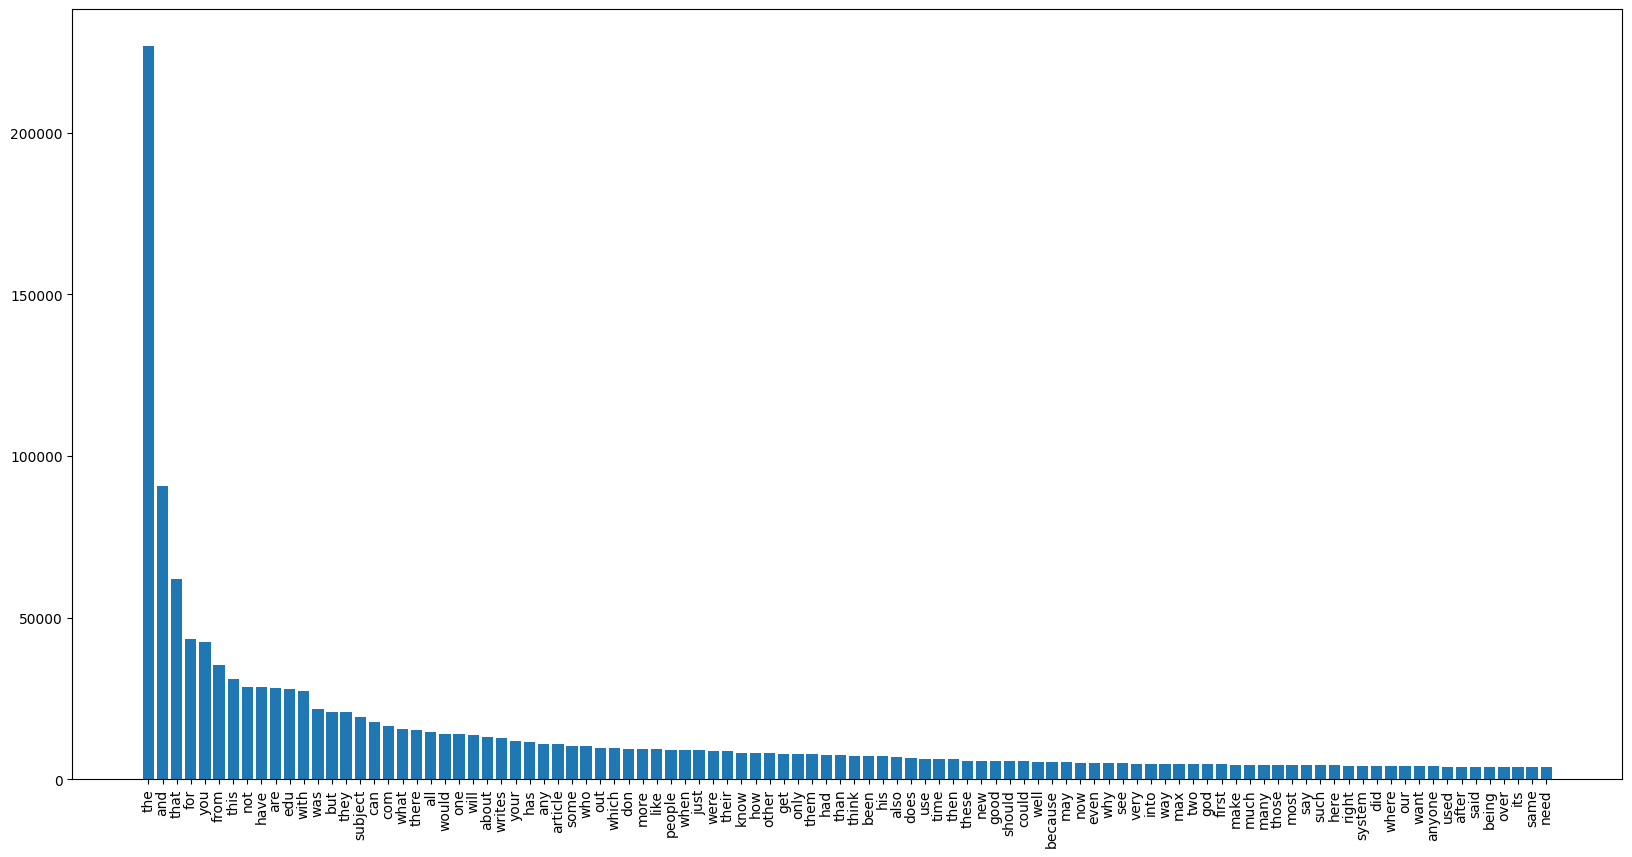

In [ ]:
fig = plt.figure()
fig.set_size_inches(20,10)

plt.bar(range(len(sorted_words[:100])), [v for k, v in sorted_words[:100]] , align='center')
plt.xticks(range(len(sorted_words[:100])), [k for k, v in sorted_words[:100]])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

### 1.2 Pre-processing to remove most and least frequent words

We can see that different words appear with different frequencies.

The most common words appear in almost all documents. Hence, for a classification task, having information about those words' frequencies does not mater much since they appear frequently in every type of document. To get a good feature representation, we eliminate them since they do not add too much value.

Additionally, notice how the least frequent words appear so rarely that they might not be useful either.

Let us pre-process our news articles now to remove the most frequent and least frequent words by thresholding their counts:

In [ ]:
def cleaning_vocabulary_words(list_of_grams):
  valid_words = defaultdict(int)

  print('Number of words before preprocessing:', len(list_of_grams))

  # Ignore the 25 most frequent words, and the words which appear less than 100 times
  ignore_most_frequent = 25
  freq_thresh = 100
  feature_number = 0
  for word, word_frequency in list_of_grams[ignore_most_frequent:]:
      if word_frequency > freq_thresh:
          valid_words[word] = feature_number
          feature_number += 1
      elif '_' in word:
          valid_words[word] = feature_number
          feature_number += 1

  print('Number of words after preprocessing:', len(valid_words))

  vector_size = len(valid_words)
  return valid_words, vector_size

In [ ]:
valid_words, number_of_words = cleaning_vocabulary_words(sorted_words)

Number of words before preprocessing: 89599
Number of words after preprocessing: 4096


### 1.3 Bag-of-Words representation

The simplest way to represent a document $D$ as a vector $V$ would be to now count the relevant words in the document.

For each document, make a vector of the count of each of the words in the vocabulary (excluding the words removed in the previous step - the "stopwords").

In [ ]:
def convert_to_BoW(dataset, number_of_documents):
    bow_representation = np.zeros((number_of_documents, number_of_words))
    labels = np.zeros((number_of_documents, 1))

    i = 0
    for label, class_name in enumerate(dataset):

        # For each file
        for f in dataset[class_name]:

            # Read all text in file
            text = ' '.join(f).split(' ')

            # For each word
            for word in text:
                if word in valid_words:
                    bow_representation[i, valid_words[word]] += 1

            # Label of document
            labels[i] = label

            # Increment document counter
            i += 1

    return bow_representation, labels

# Convert the dataset into their bag of words representation treating train and test separately
train_bow_set, train_bow_labels = convert_to_BoW(train_set, n_train)
test_bow_set, test_bow_labels = convert_to_BoW(test_set, n_test)

### 1.4 Document classification using Bag-of-Words

For the test documents, use your favorite distance metric (Cosine, Eucilidean, etc.) to find similar news articles from your training set and classify using kNN.

In [ ]:
# Optimized K-NN:- This does the same thing as you've learned but in an optimized manner
def dist(train_features, given_feature):
    squared_difference = (train_features - given_feature)**2
    distances = np.sqrt(np.sum(squared_difference, axis = 1))
    return distances

'''
 Optimized K-NN code. This code is the same as what you've already seen, but trades off memory efficency
 for computational efficency.
'''
def kNN(k, train_features, train_labels, given_feature):
    distances = []

    n = train_features.shape[0]

    # np.tile function repeats the given_feature n times.
    given_feature = np.tile(given_feature, (n, 1))

    # Compute distance
    distances = dist(train_features, given_feature)
    sort_neighbors = np.argsort(distances)
    return np.concatenate((distances[sort_neighbors][:k].reshape(-1, 1), train_labels[sort_neighbors][:k].reshape(-1, 1)), axis = 1)

def kNN_classify(k, train_features, train_labels, given_feature):
    tally = collections.Counter()
    tally.update(str(int(nn[1])) for nn in kNN(k, train_features, train_labels, given_feature))
    return int(tally.most_common(1)[0][0])

For example, using 3 nearest neighbours, the $0^{th}$ test document is classified as:

Computing accuracy for the bag-of-words features on the full test set:

It takes some time to run this cell

In [ ]:
accuracy = 0
for i, given_feature in enumerate(test_bow_set):
    print("Progress: {0:.04f}".format((i+1)/len(test_bow_set)), end="\r")
    predicted_class = kNN_classify(3, train_bow_set, train_bow_labels, given_feature)
    if predicted_class == int(test_bow_labels[i]):
        accuracy += 1
BoW_accuracy = (accuracy / len(test_bow_set))

<ipython-input-39-ee7e0b4cefec>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if predicted_class == int(test_bow_labels[i]):


In [ ]:
print(BoW_accuracy)

0.5548387096774193


# 2. Word2Vec

## 2.1 Load pre-trained Word2Vec

Let us now proceed to load the complete pretrained vectors.

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('AIML_DS_GOOGLENEWS-VECTORS-NEGATIVE-300_STD.bin', binary=True, limit=500000)

## 2.2 Word2Vec representation

Convert each document into average of the word2vec vectors of all valid words in document

In [ ]:
word2vec_vector_size = 300

'''
 This method converts documents to word vectors. It first checks if the word is valid according to our initial frequency
 threshold. Next, if it is, we add the precomputed word vectors together. If the word is valid, but we do not have a valid
 vector to represent the word, we add a random gaussian noise instead. Since we do not want to induce new noise each time,
 we store the same noise vector for training and test time in substitute_word_vecs variable.
'''
def convert_to_w2v(dataset, number_of_documents, substitute_word_vecs={}):
    labels = np.zeros((number_of_documents, 1))
    w2v_rep = np.zeros((number_of_documents, word2vec_vector_size))

    # Iterate over the dataset and split into words
    i = 0
    for label, class_name in enumerate(dataset):
        for f in dataset[class_name]:
            text = ' '.join(f).split(' ')
            valid_count = 1
            for word in text:

                # Check if word is valid or not according to original dataset pruning
                if word in valid_words:
                    try:
                        w2v_rep[i] += model[word]
                    except:
                        '''The word isn't in our pretrained word-vectors, hence we add a random gaussian noise
                         to account for this. We store the random vector we assigned to the word, and reuse
                         the same vector during test time to ensure consistency.'''

                        if word not in substitute_word_vecs.keys():
                            substitute_word_vecs[word] = np.random.normal(-0.25, 0.25, word2vec_vector_size)

                        w2v_rep[i] += substitute_word_vecs[word]

                    valid_count += 1

            # Average
            w2v_rep[i] = w2v_rep[i] / valid_count

            # Save label
            labels[i] = label

            i += 1

    return w2v_rep, labels, substitute_word_vecs

# Convert the train and test datasets into their word2vec representations
train_w2v_set, train_w2v_labels, substitute_word_vecs = convert_to_w2v(train_set, n_train)
test_w2v_set, test_w2v_labels,_ = convert_to_w2v(test_set, n_test, substitute_word_vecs)

## 2.3 Document classification using Word2Vec

For the test documents, use your favorite distance metric (Cosine, Eucilidean, etc.) to find similar news articles from your training set and classify using kNN.

It takes some time to run this cell.

In [ ]:
accuracy = 0
for i, given_feature in enumerate(test_w2v_set):
    print("Progress: {0:.04f}".format((i+1)/len(test_w2v_set)), end="\r")
    predicted_class = kNN_classify(3, train_w2v_set, train_w2v_labels, given_feature)
    if predicted_class == int(test_w2v_labels[i]):
        accuracy += 1


In [ ]:
W2V_accuracy = accuracy / len(test_w2v_set)

In [ ]:
label = ['BoW', 'W2V']
accuracies = [BoW_accuracy*100, W2V_accuracy*100]

In [ ]:
plt.figure(figsize=(5,5))
index = np.arange(len(label))
plt.bar(index, accuracies, width = 0.2)
plt.xlabel('Representation', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xticks(index, label, fontsize=15, rotation=30)
plt.title('Compare BoW - W2V on Newsgroup classification')
for i, v in enumerate(accuracies):
    plt.text(v, i, str(v), color='red', fontweight='bold')
plt.savefig('Compare BoW-W2v on Newsgroup Classification.png')